<a href="https://colab.research.google.com/github/2303A52243/EXPLAINABLE-AI-LAB/blob/main/Explainable_AI__Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RF trained. Test accuracy: 0.967


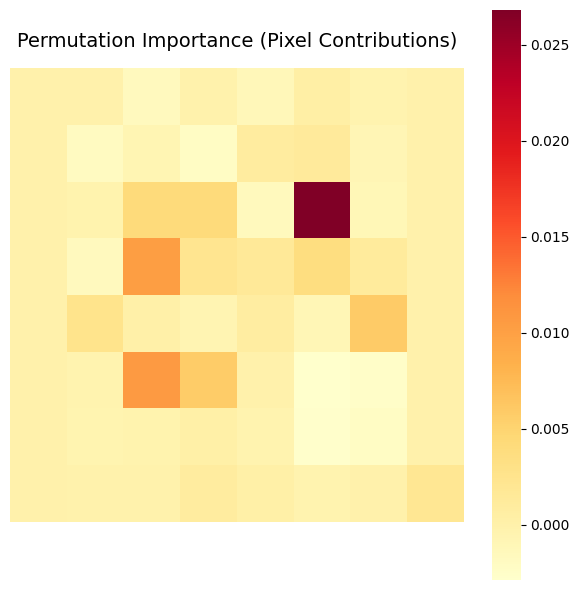

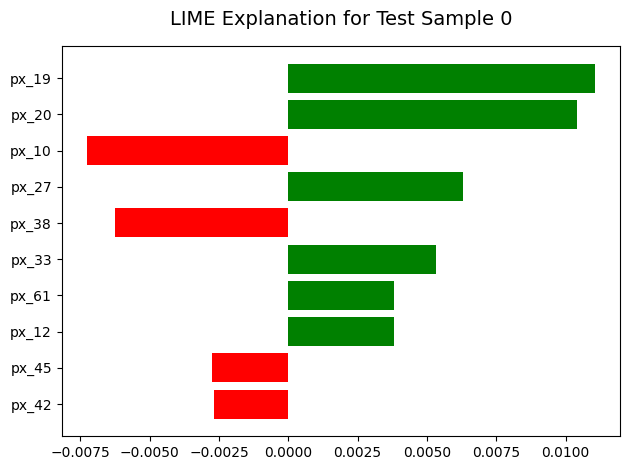

In [13]:
!pip install scikit-learn matplotlib seaborn shap lime joblib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
from lime.lime_tabular import LimeTabularExplainer
import os
import joblib

os.makedirs('outputs', exist_ok=True)

digits = load_digits()
X = digits.data
y = digits.target
feature_names = [f'px_{i}' for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print('RF trained. Test accuracy: {:.3f}'.format(rf.score(X_test, y_test)))

r = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
pi_mean = r.importances_mean

pi_map = pi_mean.reshape(8, 8)
plt.figure(figsize=(6, 6))
sns.heatmap(pi_map, cmap='YlOrRd', square=True, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Permutation Importance (Pixel Contributions)', fontsize=14, pad=15)
plt.tight_layout()
plt.savefig('outputs/pi_heatmap.png', dpi=150)
plt.show()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap_values_stacked = np.stack(shap_values, axis=0)
shap_array_abs = np.sum(np.abs(shap_values_stacked), axis=0)

if shap_array_abs.shape[1] == X_test.shape[1]:
    plt.figure(figsize=(8, 6))
    shap.summary_plot(shap_array_abs, X_test, feature_names=feature_names, show=False)
    plt.title("Global SHAP Beeswarm (Aggregated Across Classes)", fontsize=14, pad=20)
    plt.savefig('outputs/shap_beeswarm_aggregated.png', dpi=150, bbox_inches='tight')
    plt.close()
    print("SHAP beeswarm saved.")

if shap_array_abs.shape[1] == 64:
    shap_mean_abs = np.mean(shap_array_abs, axis=0).reshape(8, 8)
    plt.figure(figsize=(6, 6))
    sns.heatmap(shap_mean_abs, cmap='coolwarm', square=True, cbar=True,
                xticklabels=False, yticklabels=False, center=0)
    plt.title('Mean Absolute SHAP Values (Pixel-Level Importance)', fontsize=14, pad=15)
    plt.tight_layout()
    plt.savefig('outputs/shap_heatmap.png', dpi=150)
    plt.show()
    print("SHAP heatmap saved.")

lime_explainer = LimeTabularExplainer(
    X_train, feature_names=feature_names, class_names=[str(i) for i in digits.target_names],
    mode='classification', discretize_continuous=False
)

idx = 0
exp = lime_explainer.explain_instance(X_test[idx], rf.predict_proba, num_features=10, top_labels=1)
fig = exp.as_pyplot_figure(label=exp.available_labels()[0])
plt.title(f"LIME Explanation for Test Sample {idx}", fontsize=14, pad=15)
plt.tight_layout()
plt.savefig('outputs/lime_explanation.png', dpi=150)
plt.show()
